# Notebook 03 - API Usage Demo
本 Notebook 用于演示如何调用 `src/` 中的接口来复现我们的分析流程：

流程：
1) 读取逐分数据
2) 选择并排序一场比赛
3) 构造 point_result 和 serve-adjusted 单分贡献
4) 计算势头（momentum）
5) 检测势头转折点（swing）
6) 画图并导出到 reports/figures

注意：
- 这个 Notebook 不负责探索和调参，只负责演示“如何调用接口”。
- 参数的选择（span、amp_q、cool）会在报告/论文的敏感性分析里讨论。


In [ ]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# 将项目根目录加入 Python 路径:  非常重要！！！每个notebook如果要调用src中的模块都需要这段代码
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Added to sys.path:", PROJECT_ROOT)
# 你项目里写好的模块
from src.data.match import (
    load_raw_points_csv,
    get_match,
    add_point_result,
    add_serve_adjusted_contrib,
)

from src.features.momentum import compute_momentum
from src.features.swings import detect_swings, SwingParams
from src.viz.plots import plot_momentum_with_swings


Added to sys.path: d:\Work\tennis\mcm2024-c-tennis-momentum


## 读取原始逐分数据

我们从 `data/raw/Wimbledon_featured_matches.csv` 读入全量逐分数据。
这里只做读取，不做复杂清洗。


In [4]:
df = load_raw_points_csv("../data/raw/Wimbledon_featured_matches.csv")
df.shape, df.columns[:10]


((7284, 46),
 Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
        'point_no', 'p1_sets', 'p2_sets', 'p1_games'],
       dtype='object'))

## 选择一场比赛并按时间顺序排序

逐分数据必须按 `set_no, game_no, point_no` 排序后才能当作时间序列使用。
我们用 `get_match(df, match_id)` 完成筛选+排序。


In [5]:
df["match_id"].value_counts().head(10)


match_id
2023-wimbledon-1304    337
2023-wimbledon-1701    334
2023-wimbledon-1306    332
2023-wimbledon-1407    331
2023-wimbledon-1310    318
2023-wimbledon-1301    300
2023-wimbledon-1313    290
2023-wimbledon-1404    286
2023-wimbledon-1502    283
2023-wimbledon-1312    275
Name: count, dtype: int64

In [6]:
match_id = "2023-wimbledon-1701"   # 题面指定示例
df_match = get_match(df, match_id)
df_match.shape, df_match[["set_no","game_no","point_no"]].head()


((334, 46),
    set_no  game_no  point_no
 0       1        1         1
 1       1        1         2
 2       1        1         3
 3       1        1         4
 4       1        1         5)

## 构造单分结果与发球优势校正

### point_result
我们将每一分的胜负转成 ±1：
- Player1 赢该分：+1
- Player2 赢该分：-1

### serve-adjusted contribution
网球存在发球优势：发球方赢分是“更常见”的事件。
因此我们用 `add_serve_adjusted_contrib` 将每一分结果改写为“相对发球预期的超额表现”，并统一到 Player1 视角：
- 正值：对 Player1 有利
- 负值：对 Player2 有利


In [7]:
df_match = add_point_result(df_match)  # 新增 point_result
df_match[["point_victor", "point_result"]].head()


,point_victor,point_result
0,2,-1
1,1,1
2,1,1
3,2,-1
4,1,1


In [8]:
df_match, p_server = add_serve_adjusted_contrib(df_match)  # 新增 serve_adj / serve_adj_p1
p_server, df_match[["server", "point_victor", "serve_adj_p1"]].head()


(0.6107784431137725,
    server  point_victor  serve_adj_p1
 0       2             2     -0.389222
 1       2             1      0.610778
 2       2             1      0.610778
 3       2             2     -0.389222
 4       2             1      0.610778)

## 计算势头 momentum

我们提供 3 种势头计算方式：
- method="rm"：rolling mean（baseline）
- method="ewm"：EWMA（对 point_result）
- method="srv_ewm"：EWMA（对 serve_adj_p1，推荐）

这三者对比时，可以解释“为什么引入发球校正会更贴合网球语义”。


In [9]:
m_rm = compute_momentum(df_match, method="rm", window=15)
m_ewm = compute_momentum(df_match, method="ewm", span=25)
m_srv = compute_momentum(df_match, method="srv_ewm", span=25)

m_rm.head(), m_ewm.head(), m_srv.head()


(0   -1.000000
 1    0.000000
 2    0.333333
 3    0.000000
 4    0.200000
 Name: point_result, dtype: float64,
 0   -1.000000
 1   -0.846154
 2   -0.704142
 3   -0.726900
 4   -0.594062
 Name: point_result, dtype: float64,
 0   -0.389222
 1   -0.312298
 2   -0.241293
 3   -0.252672
 4   -0.186252
 Name: serve_adj_p1, dtype: float64)

## 检测势头转折点（swing）

我们将 swing 定义为：
- 势头趋势发生反转（上升→下降 或 下降→上升）
- 且势头幅度超过自适应阈值（分位数阈值）
- 对连续反转区间进行压缩，只保留最代表的一点
- 可选冷却时间 cool，避免 swing 过密

核心参数：
- trend_span：斜率平滑程度（越大越稳）
- amp_q：幅度阈值分位数（越大越严格）
- cool：相邻 swing 最小间隔（越大越稀疏）


In [10]:
params = SwingParams(trend_span=5, amp_q=0.85, cool=15)
swing_flag, swing_pos, amp_thr = detect_swings(m_srv, params=params)

print("p_server =", round(p_server, 3))
print("amp_thr  =", round(amp_thr, 3))
print("swing_count =", int(swing_flag.sum()))

df_match.loc[swing_flag == 1, ["set_no", "game_no", "point_no"]].head(10)


p_server = 0.611
amp_thr  = 0.174
swing_count = 3


,set_no,game_no,point_no
13,1,2,14
34,1,5,35
208,3,7,209


## 可视化与导出

使用 `plot_momentum_with_swings`：
- 绘制势头曲线（EWMA）
- 在 swing 点处做标记
- 可选保存到 `reports/figures/`


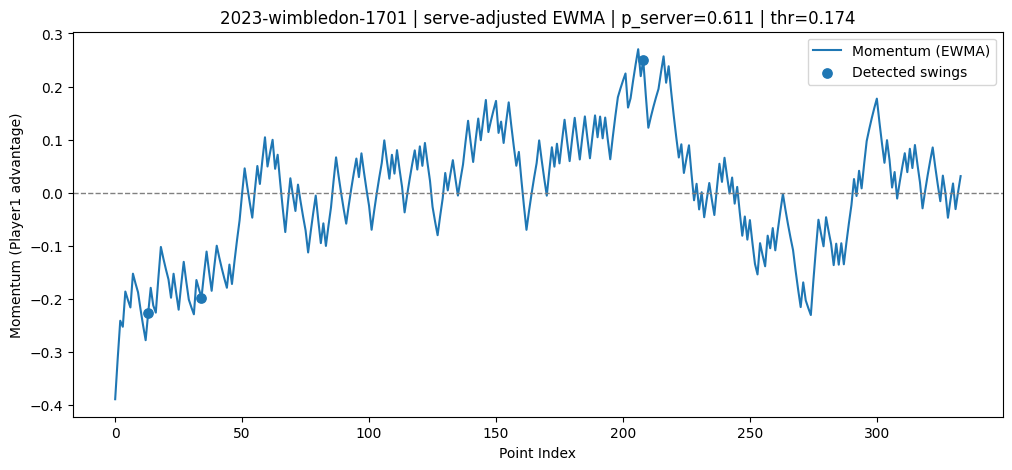

In [11]:
out_path = f"../reports/figures/{match_id}_srv_ewm_swings.png"

plot_momentum_with_swings(
    m_srv,
    swing_flag=swing_flag,
    title=f"{match_id} | serve-adjusted EWMA | p_server={p_server:.3f} | thr={amp_thr:.3f}",
    out_path=out_path,
)


## （可选）导出 swing 事件表

为了方便队友写论文，我们可以把 swing 点对应的关键字段导出成 CSV：
- set_no / game_no / point_no
- 当前势头值 m


In [12]:
events = df_match.loc[swing_flag == 1, ["set_no", "game_no", "point_no"]].copy()
events["momentum"] = m_srv.loc[events.index].values

csv_out = f"../reports/figures/{match_id}_swing_events.csv"
events.to_csv(csv_out, index=False)

events.head(), csv_out


(     set_no  game_no  point_no  momentum
 13        1        2        14 -0.226655
 34        1        5        35 -0.197801
 208       3        7       209  0.249720,
 '../reports/figures/2023-wimbledon-1701_swing_events.csv')